In [22]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import os

import os, sys,glob, copy
sys.path.append("/Users/xiaoxuanj/work/work_allen/Ephys/neuropixels_platform_paper/common")


In [2]:
from scipy import signal
def autocorr(x):
    """
    x is 1 d
    """
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]

def autocorr2D(x):
    
    corr = signal.correlate(x, x, mode='same')
    return corr

In [23]:
def load_npz(filename):
    """
    load npz files with sparse matrix and dimension
    output dense matrix with the correct dim
    """
    npzfile = np.load(filename, allow_pickle=True) 
    sparse_matrix = npzfile['arr_0'][0]
    ndim=npzfile['arr_0'][1]

    new_matrix_2d = np.array(sparse_matrix.todense())
    new_matrix = new_matrix_2d.reshape(ndim)
    return new_matrix


def get_bootstrap_95ci(M, N=5000):
    n = int(len(M)/2)
    est = np.zeros((N,))
    for i in range(N):
        boot = M[np.random.permutation(len(M))[:n]]
        est[i] = np.nanmedian(boot)
        
    return np.percentile(est,97.5) - np.nanmedian(est)



In [27]:
import cmocean  
name='seaborn'
if name=='cmocean':
    hierarchy_colors = cmocean.cm.phase(np.arange(1.0,0.1,-0.124))           
    color_bank = {'LGd' : hierarchy_colors[0],
                  'VISp' : hierarchy_colors[1],
                  'VISl' : hierarchy_colors[2],
                  'VISrl' : hierarchy_colors[3],
                  'LP' : hierarchy_colors[4],
                  'VISal' : hierarchy_colors[5],
                  'VISpm' : hierarchy_colors[6],
                  'VISam' : hierarchy_colors[7],
                 }

if name=='seaborn':
    colors = [[217,141,194],
              [129,116,177],
              [78,115,174],
              [101,178,201],
              [88,167,106],
              [202,183,120],
              [219,132,87],
              [194,79,84]]

    def scale_colors(color):
        return [col/255. for col in color]

    hierarchy_colors = [scale_colors(col) for col in colors]

    color_bank = {
            'VISp' : hierarchy_colors[1],
            'VISl' : hierarchy_colors[2],
            'VISal' : hierarchy_colors[5],
            'VISrl' : hierarchy_colors[3],
            'VISpm' : hierarchy_colors[6],
            'VISam' : hierarchy_colors[7],


            'DG' : '#A4A4A4',
            'CA3' : '#6D6D6D',
            'CA1' : '#5B5B5B',
            'CA2' : '#5B5B5B',
            'CA' : '#7ED04B',
            'POST' : '#A4A4A4',
            'SUB' : '#A4A4A4',
            'HPC' : '#A4A4A4',

            'LGd' : hierarchy_colors[0],
            'LP' : hierarchy_colors[4]
            }

areas = ('LGd','VISp','VISl','VISrl','LP','VISal','VISpm','VISam')
#areas = ('VISp','VISl','VISrl','VISal','VISpm','VISam')
HS = [-0.515, -0.357, -0.093, -0.059, 0.105, 0.152,0.327, 0.441]
HSA = [-0.6329, -0.4209, -0.08555, -0.054969, 0.17871887, 0.0226128859, 0.112409304, 0.274742343]
HS_C = [-0.357, -0.093, -0.059, 0.152,0.327, 0.441]


In [5]:
areas_all = ['LGd', #LGN
         'VISp', 'VISl', 'VISal', 'VISrl', 'VISam', 'VISpm', 'VISmma', #VIS
         'LP','TH', # thalamus
         'MB','MGm', 'MGv', 'MGd', 'APN','Eth','POL','ProS' ,'NOT', 'VPM','RPF','SGN', 'PRE', 'POST', 'SUB', 'HPF', 'ZI', 'IntG', # others
         'DG','CA1', 'CA3', # hippo
         'none'   # not labeled
        ]

In [7]:
df_exp=pd.read_csv('/Volumes/local1/work_allen/Ephys/resorted/experiment_table_2019-08-27.csv', index_col=0)
df_exp['stimulus_set'].unique()

mouseIDs = ['mouse'+str(i) for i in df_exp.index.values]
print(len(mouseIDs))

58


# with nwb2.0 units table

In [97]:
df = pd.read_csv('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/unit_table/unit_table_20190903.csv')

AMO=[]
SEP=[]
m_id=[]
sep_start=0
probes = []
for ii, mouseID in enumerate(mouseIDs):
    print(mouseID)
    # 1. load spikes
    basepath = '/Volumes/local1/work_allen/Ephys/resorted/'+mouseID
    if os.path.isfile('/Volumes/local1/work_allen/Ephys/resorted/'+mouseID+'/matrix/flash_all_units.npz'):
        spikes = load_npz(basepath+'/matrix/flash_all_units.npz')
        # add area without layer
        # with the new file, can't load with index_col
        df_old = pd.read_csv(basepath+'/matrix/'+mouseID+'_all_units_meta.csv')
        
        selection = (df.mouse == int(mouseID[5:])) & \
                (df.p_value_rf < 0.01) & \
                (df.firing_rate_fl > 0.1) & \
                (df.area_rf < 2500) & \
                (df.snr > 1)
                
        df_new = df[selection]
        df_new = df_new.reset_index().drop(['index'], axis=1)
        
        # select units in matrix satisfy df_new
        idx=[]
        A=[]
        for index, row in df_old.iterrows():
            probe = row['probe_id']
            unit_id = row['unit_id']
            if unit_id in df_new[df_new['probe_description']==probe].local_index_unit.values:
                idx.append(index)
                A.append(df_new[(df_new['probe_description']==probe) & (df_new['local_index_unit']==unit_id)].structure_acronym.values[0])
            
        df_select = df_old.iloc[idx]
        df_select = df_select.reset_index().drop(['index'], axis=1)
        df_select['areas_group']=A
        spikes = spikes[idx, :,:,:]
        assert len(df_select)==spikes.shape[0]

        probenames = df_select.probe_id.unique().astype(str)
        separations = [0]
        #separations[-1]=separations[-1]-1
        for probe in probenames:
            index = np.where(df_select.probe_id==probe)[0]
            separations = np.concatenate([separations, [index[-1]+1]],axis=0)

        ACCG=np.zeros((spikes.shape[0], spikes.shape[-1]))
        for i in range(spikes.shape[0]):
            x = spikes[i,0,:,:]
            tmp = autocorr2D(x)
            ACCG[i,:]=tmp.mean(0)
        
        print(ACCG.shape)
        
        if ii==0:
            AMO=ACCG
            probes = df_select.areas_group
            m_id.append([mouseID]*len(df_select))
        else:
            AMO=np.concatenate([AMO, ACCG], axis=0)
            probes = np.concatenate([probes, df_select.areas_group], axis=0)
            m_id.append([mouseID]*len(df_select))

        separations=separations+sep_start
        SEP.append(separations)
        sep_start=separations[-1]
m_id = [item for sublist in m_id for item in sublist] 

mouse386129
(504, 250)
mouse387858
(356, 250)
mouse388521
(440, 250)
mouse403407
(362, 250)
mouse404551
(346, 250)
mouse404553
(461, 250)
mouse404554
(404, 250)
mouse404555
(359, 250)
mouse404568
(351, 250)
mouse404569
(301, 250)
mouse404570
(354, 250)
mouse404571
(448, 250)
mouse405751
(453, 250)
mouse405755
(446, 250)
mouse406805
(288, 250)
mouse406807
(445, 250)
mouse406808
(600, 250)
mouse407972
(347, 250)
mouse408152
(274, 250)
mouse410315
(336, 250)
mouse410343
(359, 250)
mouse412791
(379, 250)
mouse412792
(322, 250)
mouse412793
(473, 250)
mouse412794
(557, 250)
mouse412799
(269, 250)
mouse412802
(393, 250)
mouse412803
(343, 250)
mouse412804
(492, 250)
mouse412809
(466, 250)
mouse415148
(496, 250)
mouse415149
(471, 250)
mouse416356
(339, 250)
mouse416357
(227, 250)
mouse416861
(560, 250)
mouse417678
(376, 250)
mouse418196
(370, 250)
mouse419112
(409, 250)
mouse419114
(446, 250)
mouse419116
(417, 250)
mouse419117
(373, 250)
mouse419118
(493, 250)
mouse419119
(527, 250)
mouse421338

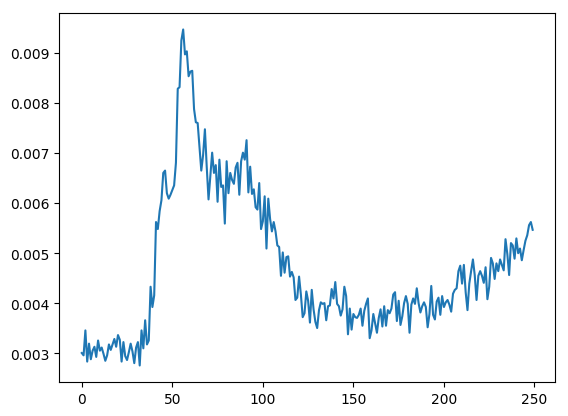

In [98]:
plt.plot(spikes.mean(0).mean(0).mean(0))

In [99]:
a = 0
for probe in np.unique(probes):
    print(probe, len(np.where(probes==probe)[0]))
    a+=len(np.where(probes==probe)[0])
print(a)

('APN', 664)
('CA1', 112)
('CA3', 59)
('DG', 46)
('Eth', 26)
('HPF', 7)
('IGL', 45)
('IntG', 16)
('LD', 30)
('LGd', 987)
('LGv', 159)
('LP', 1784)
('LT', 4)
('MB', 53)
('MGd', 3)
('MGm', 10)
('MGv', 27)
('NOT', 264)
('OP', 12)
('PO', 17)
('POL', 59)
('PP', 7)
('PPT', 22)
('PoT', 2)
('ProS', 21)
('SCig', 38)
('SCiw', 1)
('SGN', 55)
('SUB', 33)
('TH', 59)
('VIS', 679)
('VISal', 2938)
('VISam', 2876)
('VISl', 2165)
('VISli', 285)
('VISmma', 289)
('VISmmp', 77)
('VISp', 4140)
('VISpm', 1819)
('VISrl', 2319)
('VPM', 12)
('ZI', 17)
('none', 1039)
23277


# plot autocorrelation in each area averaged across mice

In [100]:
areas = ('LGd','VISp','VISl','VISrl','LP','VISal','VISpm','VISam')

m = []
for i, probe in enumerate(areas):
    #plt.plot(np.nanmean(AMO[np.where(probes==probe)[0],:], axis=0), c=color_bank[probe])
    m.append(max(np.nanmean(AMO[np.where(probes==probe)[0],:], axis=0)))   


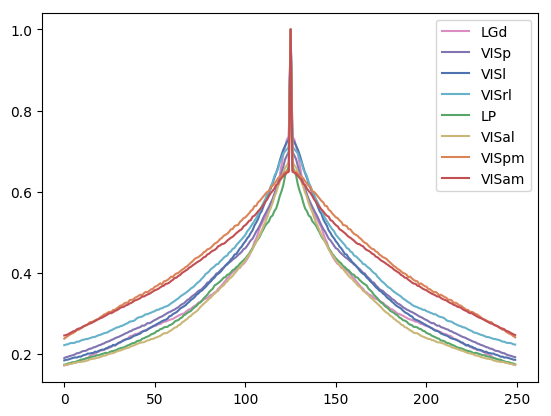

In [101]:
for i, probe in enumerate(areas):
    plt.plot(np.nanmean(AMO[np.where(probes==probe)[0],:], axis=0)/m[i], c=color_bank[probe], label=probe)
plt.legend()
#plt.xlim([500, 1000])
#plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/platform_paper/hierarchy/ACCG_all.pdf')

# fit

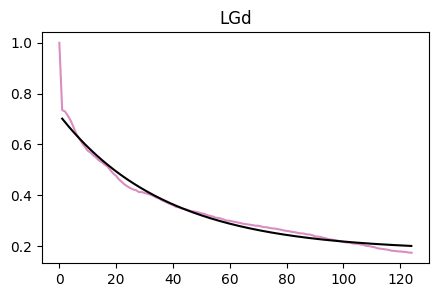

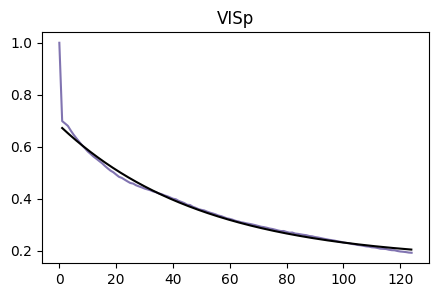

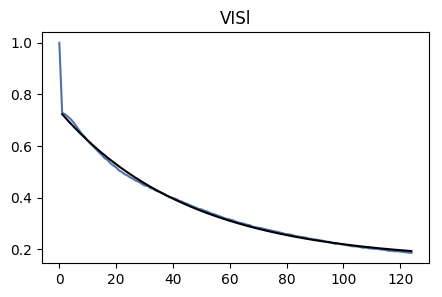

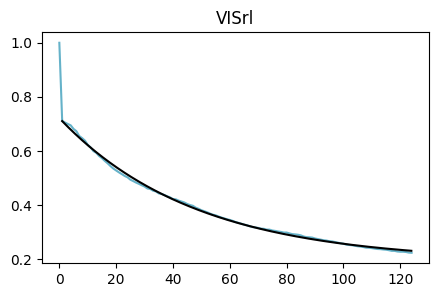

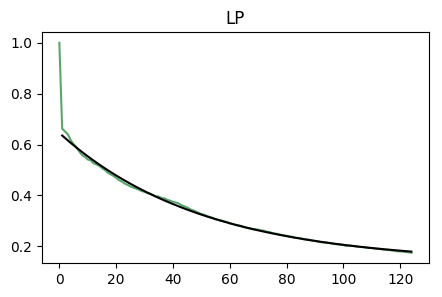

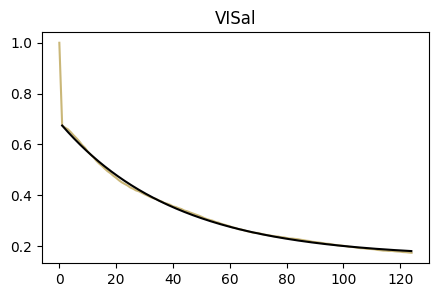

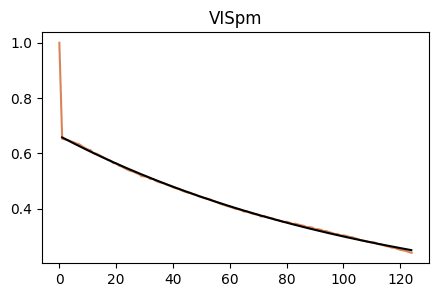

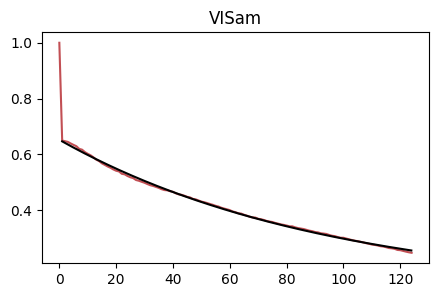

In [116]:
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

intrinsic=[]
FIT=[]
Y=[]

for i, probe in enumerate(areas):
    tmp = np.nanmean(AMO[np.where(probes==probe)[0],125:], axis=0)/m[i]
    
    plt.figure(figsize=(5,3))
    plt.plot(tmp, c=color_bank[probe])

    t = np.arange(len(tmp))[1:]
    y = tmp[1:]
    
    p, amo = curve_fit(lambda t,a,b,c: a*np.exp(-1/b*t)+c,  t,  y,  p0=(0.5, 20, 0.1), maxfev = 1000000000)

    a=p[0]
    b=p[1]
    c=p[2]
    fit_y_original = a*np.exp(-1/b*t)+c
    err = 1-(np.var(y-fit_y_original)/np.var(y))
    
    xspacing = 0.1
    xt = np.arange(min(t), max(t),xspacing)
    fit_y = a*np.exp(-1/b*xt)+c
    
    #p0=[-4, -1, 1]
    #A, K, C = ef.fit_exp_nonlinear(t, y, p0)
    #fit_y = ef.model_func(t, A, K, C)
    plt.plot(xt, fit_y, 'k-',)
    #plt.errorbar(t, y, np.nanstd(tmp, axis=0)[1:]/np.sqrt(n))
    #plt.plot(np.nanmean(tmp, axis=0)[:20])
    plt.title(probe)
    intrinsic.append([a,b,c])
    FIT.append(fit_y)
    Y.append(y)
    #plt.ylim([0.2, 0.4])
    #plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/intrinsic_timescale/summary_BOb+FCmice_flash_bin25_'+probe+'.pdf')

([0.5346036953895134, 37.264997971112656, 0.1808947260880496], 74.52999594222531)
([0.5219949488262163, 50.2550832655018, 0.16056677478536047], 100.5101665310036)
([0.5815355727945313, 45.50511189449764, 0.15425915799501433], 91.01022378899528)
([0.5304085159704691, 47.93234306065363, 0.1909245198331338], 95.86468612130726)
([0.5095355456510321, 50.32886155119899, 0.13604967833701176], 100.65772310239798)
([0.531913436760975, 40.38613022980298, 0.15521927503775446], 80.77226045960596)
([0.6273934410647378, 115.55046869451137, 0.036135956979608266], 231.10093738902273)
([0.5439332525641851, 94.70755469802474, 0.10824374126325033], 189.41510939604947)


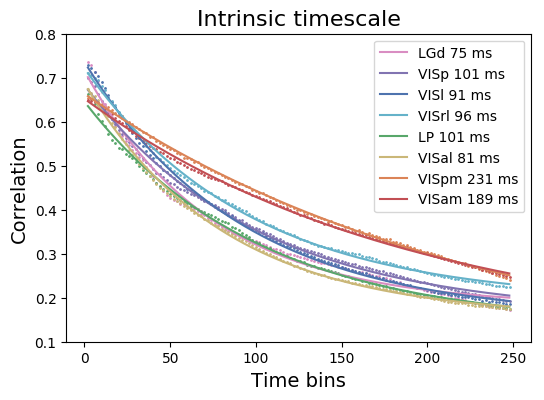

In [119]:
plt.style.use('default')

plt.figure(figsize=(6,4))
for i in range(8):
    probe=areas[i]
    tau = intrinsic[i][1]*2
    plt.scatter(t*2, Y[i], c=color_bank[probe], s=1)
    plt.plot(xt*2, FIT[i],c=color_bank[probe], label=probe+' '+str(int(round(tau)))+' ms')
    print(intrinsic[i], tau)
plt.xlabel('Time bins', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.title('Intrinsic timescale', fontsize=16)
plt.ylim([0.1,0.8])
#plt.xlim([200,1000])
plt.legend()
plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/platform_paper/hierarchy/ACCG_all_fit_consistent.pdf')

# Calculate decay rate of autocorrelation in each mouse

In [104]:
mouseIDs=np.unique(np.array(m_id))
print(mouseIDs)

['mouse386129' 'mouse387858' 'mouse388521' 'mouse403407' 'mouse404551'
 'mouse404553' 'mouse404554' 'mouse404555' 'mouse404568' 'mouse404569'
 'mouse404570' 'mouse404571' 'mouse405751' 'mouse405755' 'mouse406805'
 'mouse406807' 'mouse406808' 'mouse407972' 'mouse408152' 'mouse410315'
 'mouse410343' 'mouse412791' 'mouse412792' 'mouse412793' 'mouse412794'
 'mouse412799' 'mouse412802' 'mouse412803' 'mouse412804' 'mouse412809'
 'mouse415148' 'mouse415149' 'mouse416356' 'mouse416357' 'mouse416861'
 'mouse417678' 'mouse418196' 'mouse419112' 'mouse419114' 'mouse419116'
 'mouse419117' 'mouse419118' 'mouse419119' 'mouse421338' 'mouse421529'
 'mouse424445' 'mouse424448' 'mouse425597' 'mouse425599' 'mouse429857'
 'mouse432104' 'mouse432105' 'mouse433891' 'mouse434488' 'mouse434494'
 'mouse437660' 'mouse437661' 'mouse448503']


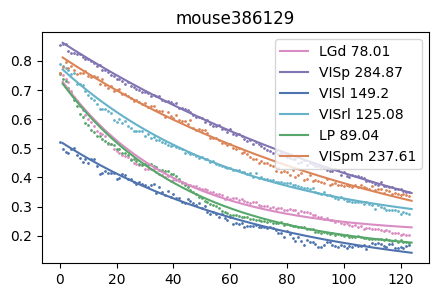

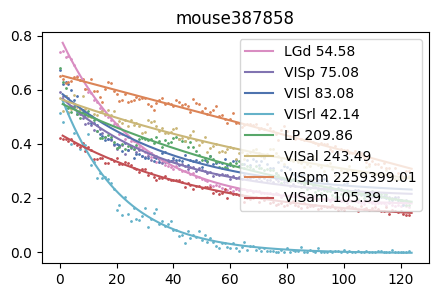

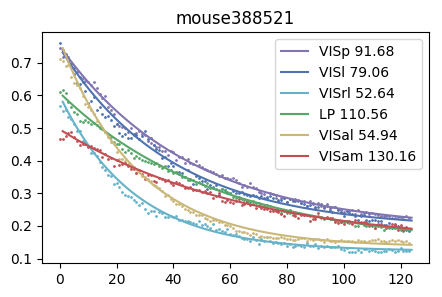

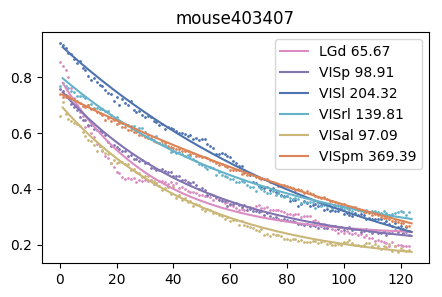

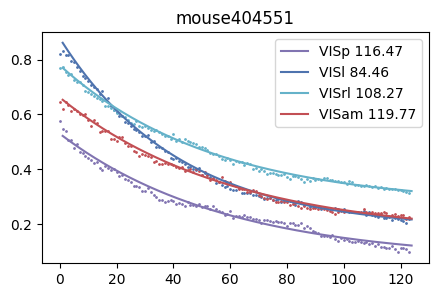

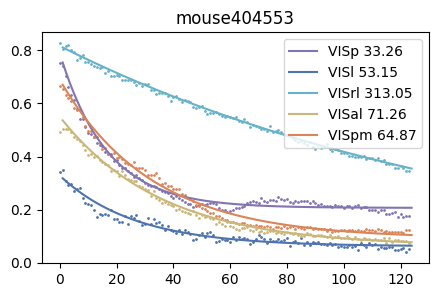

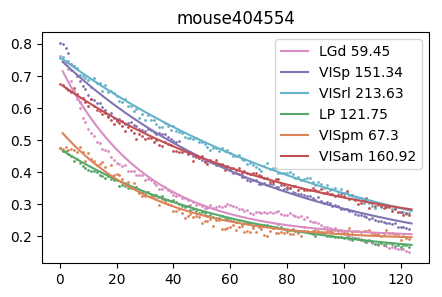

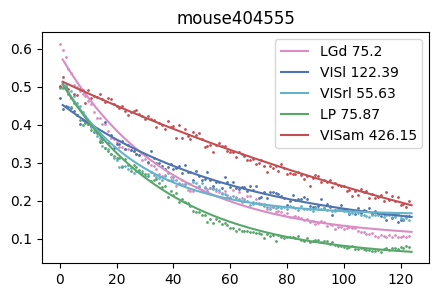

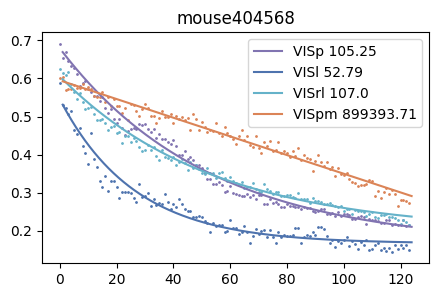

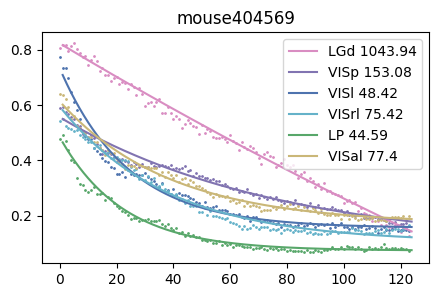

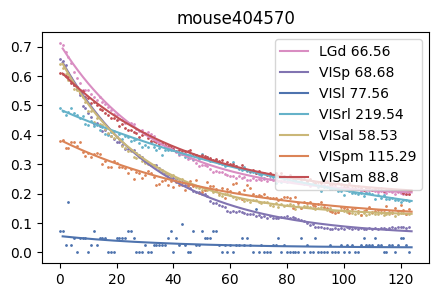

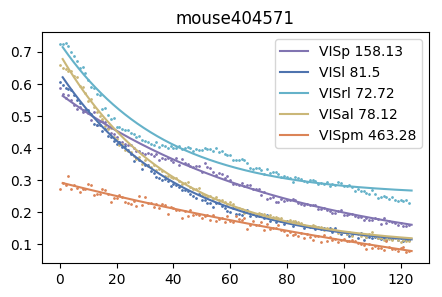

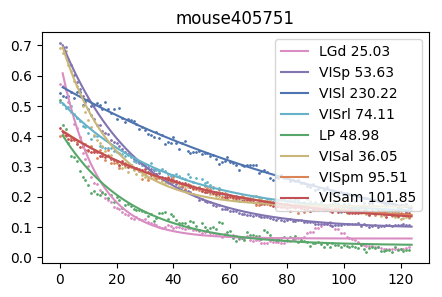

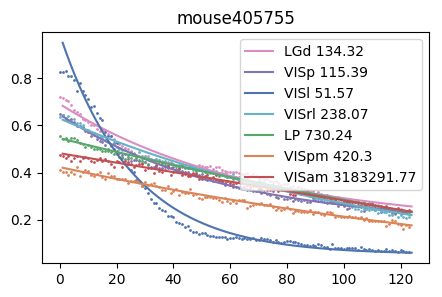

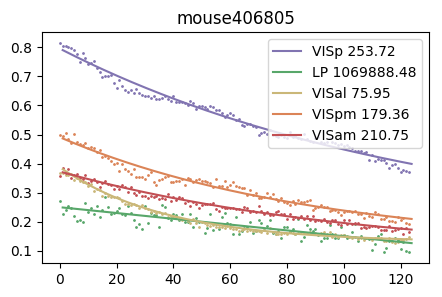

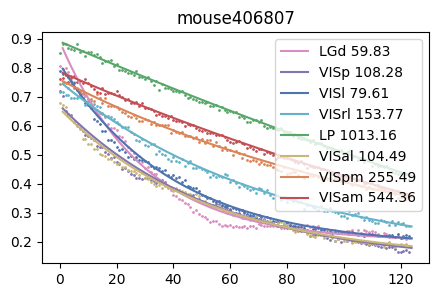

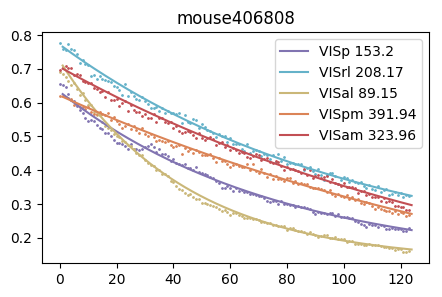

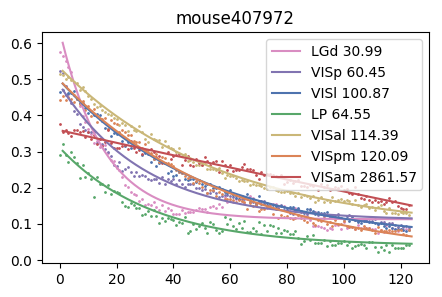

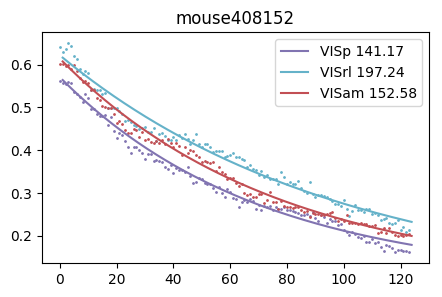

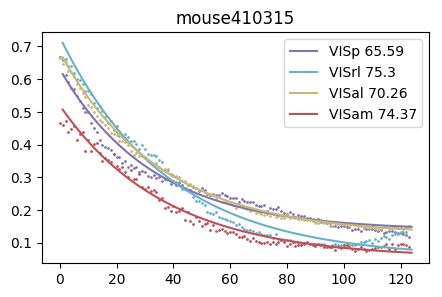

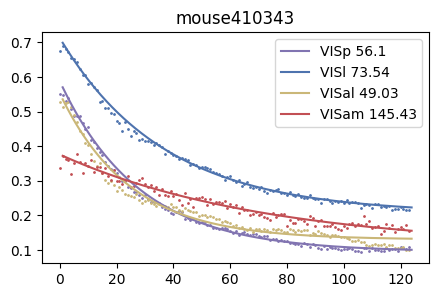

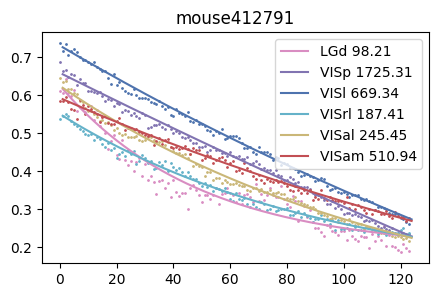

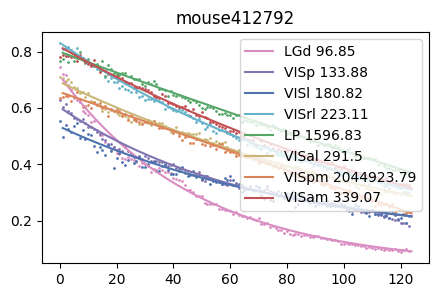

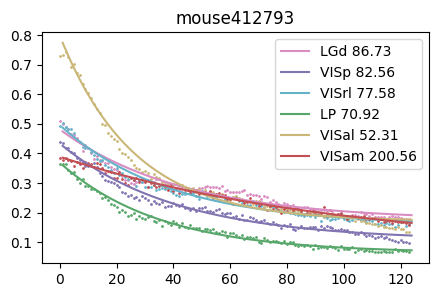

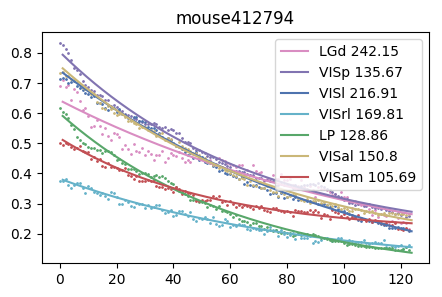

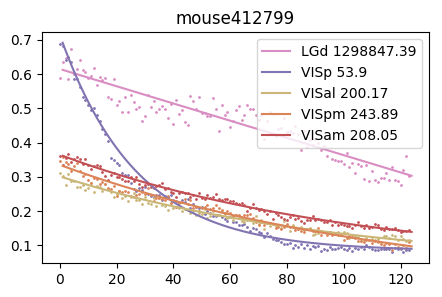

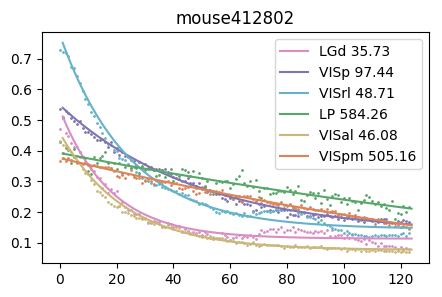

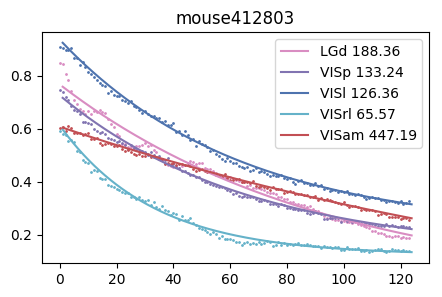

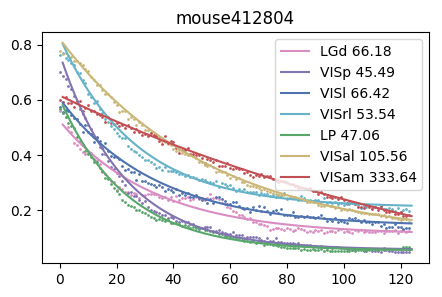

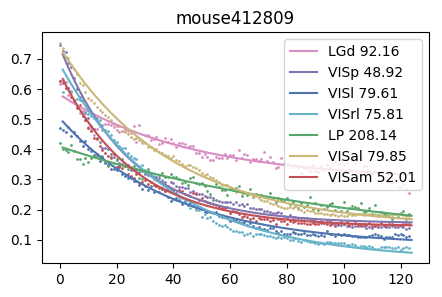

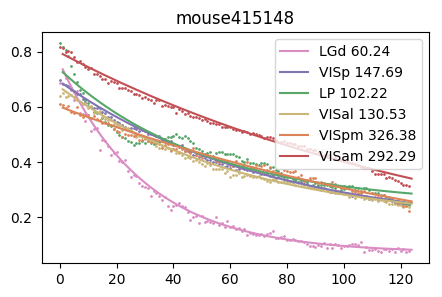

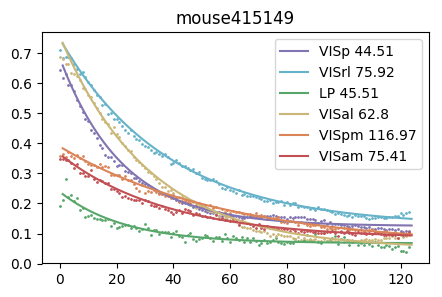

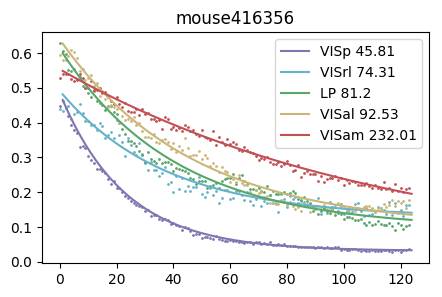

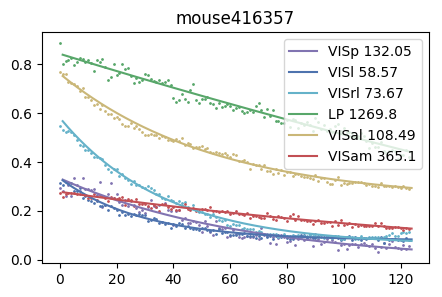

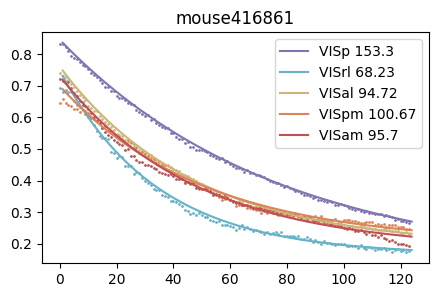

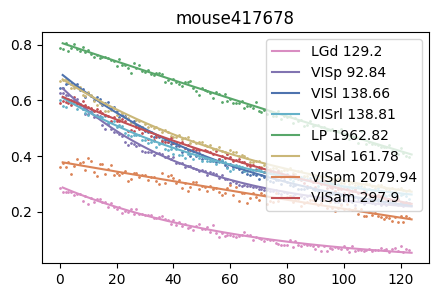

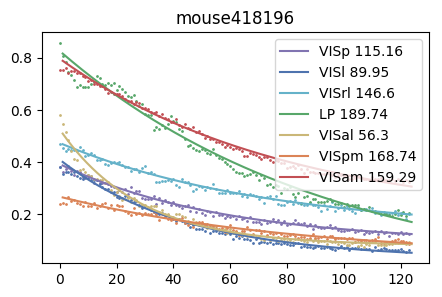

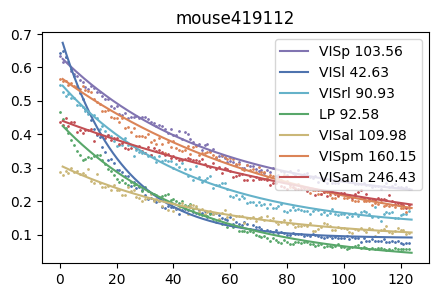

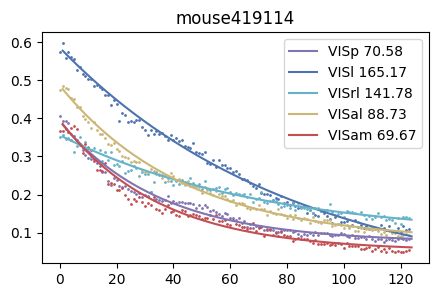

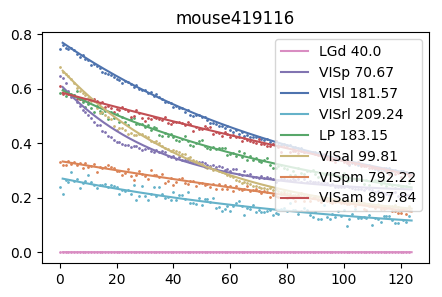

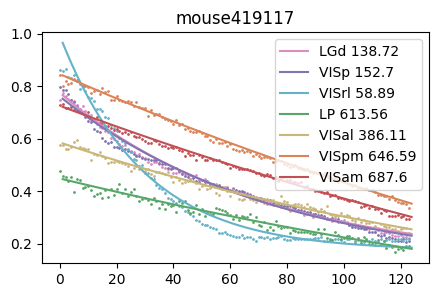

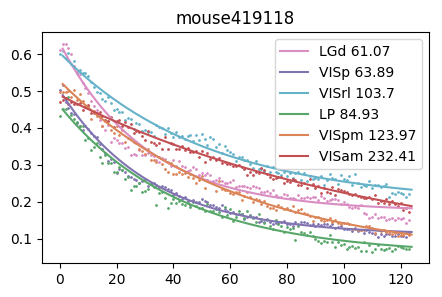

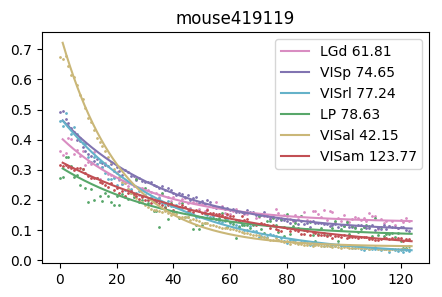

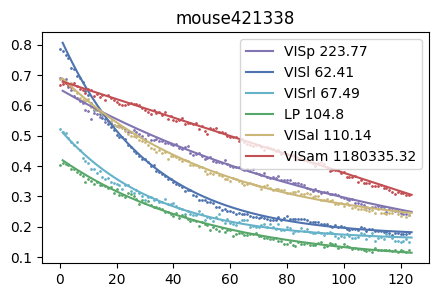

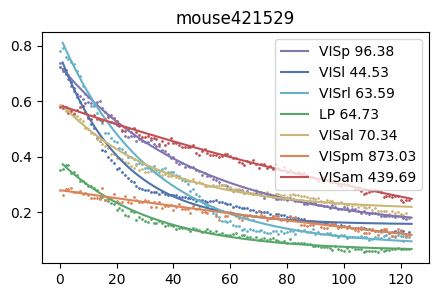

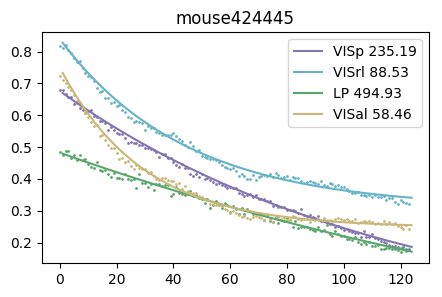

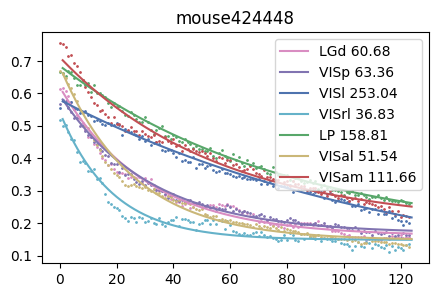

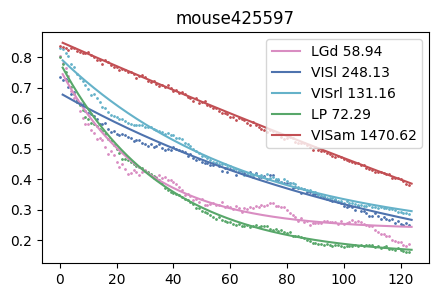

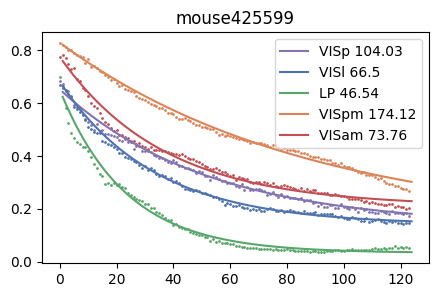

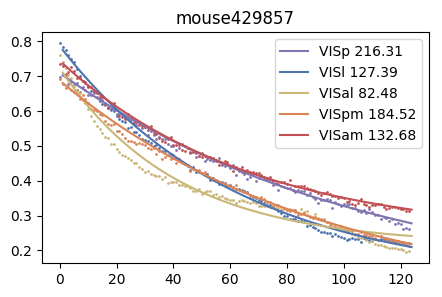

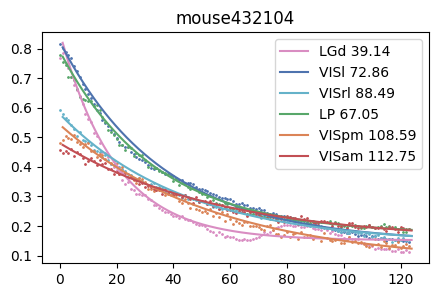

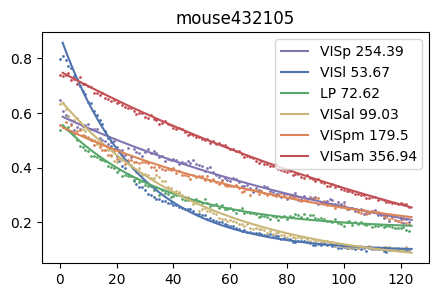

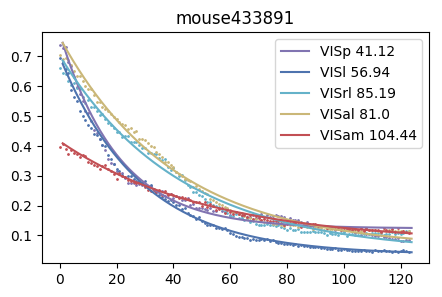

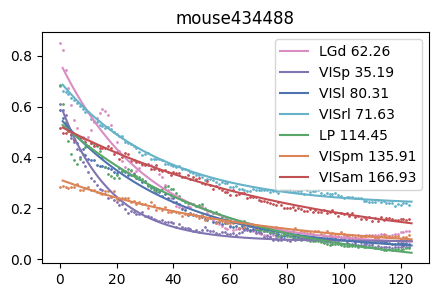

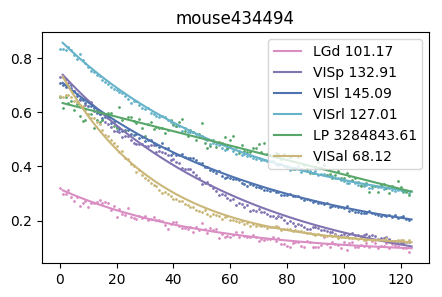

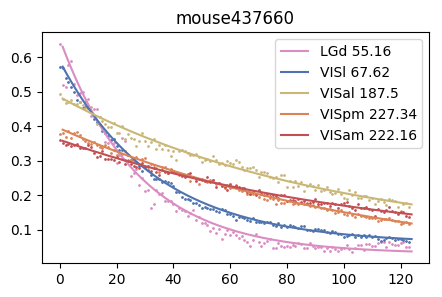

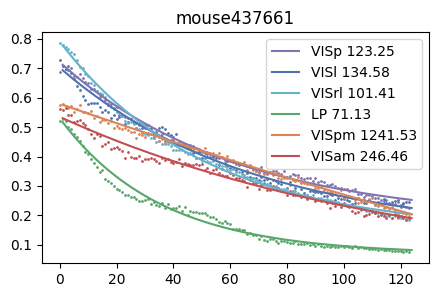

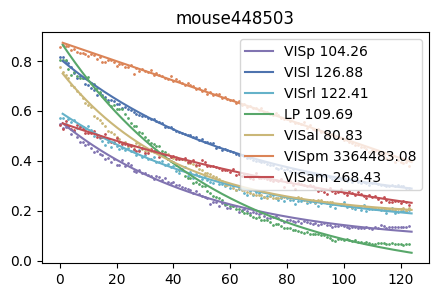

In [105]:
intrinsic_all=[]

for mouse in mouseIDs:
    
    intrinsic=np.NaN*np.zeros((len(areas),3))
    probe_tmp=probes[np.where(np.array(m_id)==mouse)[0]]
    plt.figure(figsize=(5,3))
    for i, probe in enumerate(areas):
        if probe in np.unique(probe_tmp):
            tmp = np.nanmean(AMO[np.where((probes==probe) & (np.array(m_id)==mouse))[0],125:], axis=0)
            if sum(tmp)!=0:
                tmp = tmp/max(tmp)

                plt.scatter(range(len(tmp)-1), tmp[1:], c=color_bank[probe], s=1)

                t = np.arange(len(tmp))[1:]
                y = tmp[1:]

                p, amo = curve_fit(lambda t,a,b,c: a*np.exp(-1/b*t)+c,  t,  y,  p0=(0.5, 20, 0.1), maxfev = 1000000000)

                a=p[0]
                b=p[1]
                c=p[2]
                fit_y_original = a*np.exp(-1/b*t)+c
                err = 1-(np.var(y-fit_y_original)/np.var(y))
                if err<0.9:
                    p, amo = curve_fit(lambda t,a,b,c: a*np.exp(-1/b*t)+c,  t,  y,  p0=(0.1, 20, 0.1), maxfev = 1000000000)
                    a=p[0]
                    b=p[1]
                    c=p[2]
                    fit_y_original = a*np.exp(-1/b*t)+c
                    err = 1-(np.var(y-fit_y_original)/np.var(y))
                    
                if err<0.9:
                    p, amo = curve_fit(lambda t,a,b,c: a*np.exp(-1/b*t)+c,  t,  y,  p0=(0.2, 20, 0.1), maxfev = 1000000000)
                    a=p[0]
                    b=p[1]
                    c=p[2]
                    fit_y_original = a*np.exp(-1/b*t)+c
                    err = 1-(np.var(y-fit_y_original)/np.var(y))
                    
                if err<0.9:
                    p, amo = curve_fit(lambda t,a,b,c: a*np.exp(-1/b*t)+c,  t,  y,  p0=(0.5, 20, 0.1), maxfev = 1000000000)
                    a=p[0]
                    b=p[1]
                    c=p[2]
                    fit_y_original = a*np.exp(-1/b*t)+c
                    err = 1-(np.var(y-fit_y_original)/np.var(y))

                #print(err)

                xspacing = 0.1
                xt = np.arange(min(t), max(t),xspacing)
                fit_y = a*np.exp(-1/b*xt)+c

                plt.plot(xt, fit_y, c=color_bank[probe], label=probe+' '+str(round(b*2,2)))
                plt.title(mouse)
                intrinsic[i,:]=np.array([a,b,c])
    plt.legend()
    intrinsic_all.append(intrinsic)

intrinsic_all=np.array(intrinsic_all)


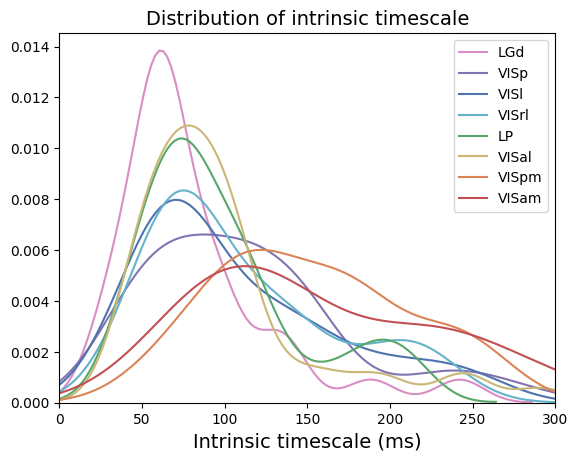

In [108]:
import seaborn as sns
dist=[]
for i, probe in enumerate(areas):
    tmp = intrinsic_all[:,i,1]*2
    tmp[np.where(tmp>300)]=np.NaN
    dist.append(tmp)
    #plt.hist(tmp[np.where(np.isnan(tmp)!=1)])
    sns.kdeplot(tmp[np.where(np.isnan(tmp)!=1)], shade=False, color = color_bank[probe], label=probe)

plt.title('Distribution of intrinsic timescale', fontsize=14)
plt.xlabel('Intrinsic timescale (ms)', fontsize=14)
plt.xlim([0, 300])
plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/platform_paper/hierarchy/intrinsic_timescale/ACCG_distribution_8area_consistent.pdf')


In [109]:
dist = np.array(dist)
np.save('/Users/xiaoxuanj/work/work_allen/Ephys/figures/platform_paper/hierarchy/intrinsic_timescale/intrinsic_timescale_units_consistent.npy', dist)

# plot mouse summary

80.81372271757408
112.69696736817743
108.74062422500205
110.4818796736351
98.67483302259413
100.67683617879811
152.99569293965868
155.16531713293648


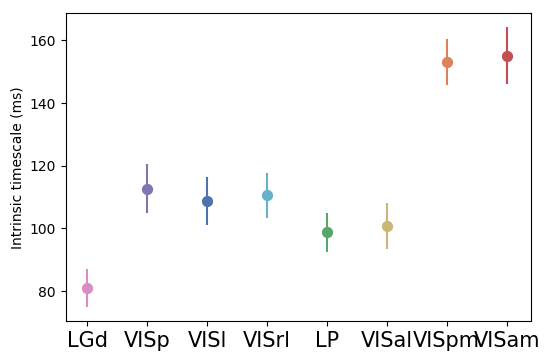

In [113]:
plt.figure(figsize=(6,4))
middle=[]
sds=[]
for i, probe in enumerate(areas):
    tmp = intrinsic_all[:,i,1]*2
    tmp[np.where(tmp>300)]=np.NaN
    
    tau = np.nanmean(tmp)
    middle.append(tau)
    sds.append(np.nanstd(tmp)/np.sqrt(len(tmp)))
    print(tau)
    plt.scatter(i, tau, c=color_bank[probe], s=50)
    plt.errorbar(i, tau, np.nanstd(tmp)/np.sqrt(len(tmp)), fmt='o', c=color_bank[probe])
    
plt.ylabel('Intrinsic timescale (ms)')
#plt.ylim([80,220])
plt.xticks(range(8), areas, fontsize=15)
#plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/intrinsic_timescale/summary_BOb+FCmice_flash_bin25_time.pdf')
#plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/platform_paper/hierarchy/intrinsic_timescale_summary_BOb+FC_flash_bin25.pdf')

plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/platform_paper/hierarchy/intrinsic_timescale/ACCG_mean_8area_consistent.pdf')


$r_S$ = 0.57; $P_S$ = 0.139
$r_P$ = 0.77; $P_P$ = 0.0265


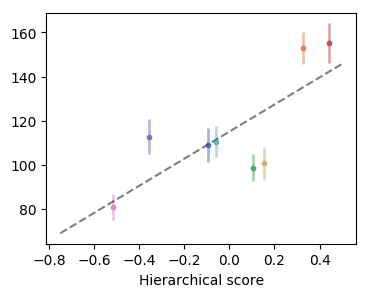

In [112]:
# correlation with hierarchy
from scipy.stats import linregress, pearsonr, spearmanr

x=HS
y = middle
plt.figure(figsize=(4,3))
for k, probe in enumerate(areas):
    plt.plot(x[k], middle[k],'.',color=color_bank[probe])
    plt.errorbar(x[k], middle[k], yerr = sds[k], fmt='.',color=color_bank[probe],alpha=0.5, linewidth=2)

slope,intercept,r,p,std = linregress(x,y)
x2 = np.linspace(-0.75,0.5,10)

plt.plot(x2,x2*slope+intercept,'--k', alpha=0.5)
plt.xlabel('Hierarchical score')

r_s,p_s = spearmanr(x,y)
r_p,p_p = pearsonr(x,y)

text = '$r_S$ = ' + str(np.around(pow(r_s,1),2)) + '; $P_S$ = ' + str(np.around(p_s,4)) + '\n' + \
          '$r_P$ = ' + str(np.around(pow(r_p,1),2)) + '; $P_P$ = ' + str(np.around(p_p,4))

print(text)
plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/platform_paper/hierarchy/intrinsic_timescale/ACCG_regression_8area_consistent.pdf')


# plot example area fit

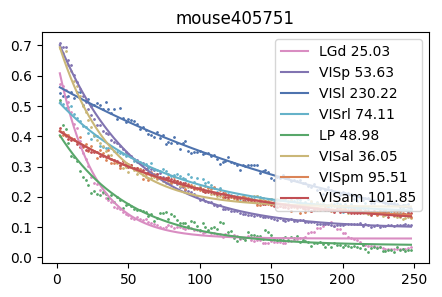

In [114]:
mouse='mouse405751'
    
intrinsic=np.NaN*np.zeros((6,3))
probe_tmp=probes[np.where(np.array(m_id)==mouse)[0]]
plt.figure(figsize=(5,3))
for i, probe in enumerate(areas):
    if probe in np.unique(probe_tmp):
        tmp = np.nanmean(AMO[np.where((probes==probe) & (np.array(m_id)==mouse))[0],125:], axis=0)
        if sum(tmp)!=0:
            tmp = tmp/max(tmp)
            t = np.arange(len(tmp))[1:]*2
            y = tmp[1:]
            
            plt.scatter(t, y, c=color_bank[probe], s=1)

            p, amo = curve_fit(lambda t,a,b,c: a*np.exp(-1/b*t)+c,  t,  y,  p0=(0.5, 20, 0.1), maxfev = 1000000000)

            a=p[0]
            b=p[1]
            c=p[2]
            fit_y_original = a*np.exp(-1/b*t)+c
            err = 1-(np.var(y-fit_y_original)/np.var(y))
            if err<0.9:
                p, amo = curve_fit(lambda t,a,b,c: a*np.exp(-1/b*t)+c,  t,  y,  p0=(0.1, 20, 0.1), maxfev = 1000000000)
                a=p[0]
                b=p[1]
                c=p[2]
                fit_y_original = a*np.exp(-1/b*t)+c
                err = 1-(np.var(y-fit_y_original)/np.var(y))

            if err<0.9:
                p, amo = curve_fit(lambda t,a,b,c: a*np.exp(-1/b*t)+c,  t,  y,  p0=(0.2, 20, 0.1), maxfev = 1000000000)
                a=p[0]
                b=p[1]
                c=p[2]
                fit_y_original = a*np.exp(-1/b*t)+c
                err = 1-(np.var(y-fit_y_original)/np.var(y))

            if err<0.9:
                p, amo = curve_fit(lambda t,a,b,c: a*np.exp(-1/b*t)+c,  t,  y,  p0=(0.5, 20, 0.1), maxfev = 1000000000)
                a=p[0]
                b=p[1]
                c=p[2]
                fit_y_original = a*np.exp(-1/b*t)+c
                err = 1-(np.var(y-fit_y_original)/np.var(y))

            #print(err)

            xspacing = 0.1
            xt = np.arange(min(t), max(t),xspacing)
            fit_y = a*np.exp(-1/b*xt)+c

            plt.plot(xt, fit_y, c=color_bank[probe], label=probe+' '+str(round(b,2)))
            plt.title(mouse)
plt.legend()
plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/platform_paper/hierarchy/intrinsic_timescale/ACCG_example_mouse405751_consistent.pdf')
